# Sequence models

Finally, we arrive at sequence models. Hopefully this will serve us better than the convolutional approach (but why would it?).

## 1. RNN for input-output with equal length
```
Input: pianoroll-unit (128, 96)
Output: pianoroll-unit (128, 96)
```

Code adapted from: https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [1]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.models import load_model

PICKLE_FILE = './pickle_jar/norm_units_50_songs.pkl'

Using TensorFlow backend.


In [2]:
units = {}
with open(PICKLE_FILE, 'rb') as infile:
    units = pickle.load( infile )
units['full'] = units['input'] + units['comp']

# Print info
print("Loaded", units["input"].shape[0], "units from", PICKLE_FILE)
print("input_units.shape: ", units["input"].shape)
print("comp_units.shape: ", units["comp"].shape)
print("full_units.shape: ", units["full"].shape)

# Create an array of True (train) and False (test) to split the dataset
train_test_indices = np.random.choice([True, False], size=len(units["input"]), p=[.9, .1])
# Training data
input_train = units["input"][train_test_indices, ...].swapaxes(1,2)
comp_train = units["comp"][train_test_indices, ...].swapaxes(1,2)
full_train = units["full"][train_test_indices, ...].swapaxes(1,2)
# Testing data
input_test = units["input"][np.invert(train_test_indices), ...].swapaxes(1,2)
comp_test = units["comp"][np.invert(train_test_indices), ...].swapaxes(1,2)
full_test = units["full"][np.invert(train_test_indices), ...].swapaxes(1,2)
print("Train:", input_train.shape)
print("Test:", input_test.shape)

('Loaded', 3831, 'units from', './pickle_jar/norm_units_50_songs.pkl')
('input_units.shape: ', (3831, 128, 96))
('comp_units.shape: ', (3831, 128, 96))
('full_units.shape: ', (3831, 128, 96))
('Train:', (3480, 96, 128))
('Test:', (351, 96, 128))


In [3]:
from __future__ import print_function
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
NUM_TICKS = 96
NUM_PITCHES = 128
REVERSE = True

MAXLEN = NUM_TICKS

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, NUM_PITCHES)))
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(MAXLEN))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(NUM_PITCHES)))
model.add(layers.Activation('relu'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 96, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 96, 128)           131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 96, 128)           16512     
_________________________________________________________________
activation_1 (Activation)    (None, 96, 128)           0         
Total params: 279,680
Trainable params: 279,680
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Train the model each generation and show predictions against the validation
# dataset.

model.fit(input_train, input_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/rnn')])

MODEL_RNN_V1_FILE = './models/rnn_v1.h5'
model.save(MODEL_RNN_V1_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_RNN_V1_FILE)

Instructions for updating:
Use the retry module or similar alternatives.
Train on 3433 samples, validate on 398 samples
Epoch 1/50
3433/3433 [==============================] - 30s 9ms/step - loss: 0.0058 - acc: 0.2666 - val_loss: 0.0049 - val_acc: 0.3286
Epoch 2/50
3433/3433 [==============================] - 29s 8ms/step - loss: 0.0044 - acc: 0.3638 - val_loss: 0.0044 - val_acc: 0.3616
Epoch 3/50
3433/3433 [==============================] - 29s 8ms/step - loss: 0.0041 - acc: 0.3969 - val_loss: 0.0042 - val_acc: 0.3625
Epoch 4/50
3433/3433 [==============================] - 29s 8ms/step - loss: 0.0039 - acc: 0.4053 - val_loss: 0.0041 - val_acc: 0.4004
Epoch 5/50
3433/3433 [==============================] - 29s 8ms/step - loss: 0.0037 - acc: 0.4117 - val_loss: 0.0039 - val_acc: 0.4092
Epoch 6/50
3433/3433 [==============================] - 29s 8ms/step - loss: 0.0037 - acc: 0.4179 - val_loss: 0.0039 - val_acc: 0.4028
Epoch 7/50
3433/3433 [==============================] - 29s 8ms/step -

NameError: name 'autoencoder' is not defined

In [3]:
MODEL_RNN_V1_FILE = './models/rnn_v1.h5'
model = load_model(MODEL_RNN_V1_FILE)

In [4]:
# Run test inputs through the autoencoder
decoded_test = model.predict(input_test)
print(decoded_test.shape)

(351, 96, 128)


(96, 128)
(96, 128)
(96, 128)


0

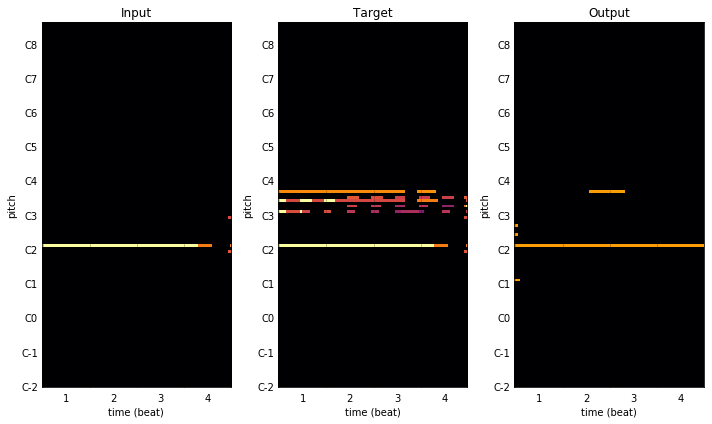

In [14]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index] * 127
sample_full = full_test[sample_index] * 127
sample_output = decoded_test[sample_index] * 127

# Set all velocity values < threshold to zero
threshold = 10
sample_output[sample_output < threshold] = 0
sample_output[sample_output >= threshold] = 100

print(sample_input.shape)
print(sample_full.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Target')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_full, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[2], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_full)
# pianoroll_utils.playPianoroll(sample_output)
pianoroll_utils.playPianoroll_events(sample_output.swapaxes(0,1))



# Sequence-to-sequence model

In [ ]:
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download
English to French sentence pairs.
http://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
http://www.manythings.org/anki/
# References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.







# START HERE

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, NUM_PITCHES))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, NUM_PITCHES))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='relu')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)